In [587]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

In [424]:
vMAX, vMIN = 5, -5
aMAX, aMIN = 10,-10
dt = 0.1
SIM_T = 50
SIM_ITRS = int(SIM_T/dt)

xGOAL = 190

VFRONT = 1.98
VREAR = 0.405
VLEN  = VFRONT+VREAR
VHW = 0.6

VLEN_1of3 = round(VLEN/3,8)

In [131]:
## World-related params
num_lanes = 2
num_cars_per_lane = [4,4]
numCars = 1+sum(num_cars_per_lane) # autoCar + agentCars
yFIRST_LANE = 18.5
LANE_WIDTH = 3.0

In [460]:
## State = (t, x, y, vx, vy)
tIdx, xIdx, yIdx, vxIdx, vyIdx = [i for i in range(5)]

# first car is autoCar, remaining agentCars
INITPOS_CARS =np.array([
    [0, 10, 21.5, 2, 0],
    [0, 25, 18.5, 2, 0],
    [0, 45, 18.5, 2, 0],
    [0, 65, 18.5, 2, 0],
    [0, 85, 18.5, 2, 0],
    [0, 20, 21.5, 3, 0],
    [0, 35, 21.5, 3, 0],
    [0, 50, 21.5, 3, 0],
    [0, 65, 21.5, 3, 0]
])

# INITPOS = INITPOS_CARS[0]


## Drivers' aggressiveness
AGGROS = [True for _ in range(numCars)]

In [147]:
## Indices for the cars (autoCar, firstCARS, CARS)
CARS = [i for i in range(numCars)]

autoCAR = 0

firstCARS =[]
MASK_AGENTS = np.array([False]+[True for _ in range(numCars-1)])
yLanes = np.array([i*LANE_WIDTH+yFIRST_LANE for i in range(num_lanes)])
for yLane in yLanes:
    mask= (INITPOS_CARS[:,yIdx]==yLane)*MASK_AGENTS
    firstCARS.append(np.argmax(INITPOS_CARS[:,xIdx]*mask))
    

laneMarkings = np.append(yLanes,yLanes[-1]+LANE_WIDTH) - LANE_WIDTH/2

In [406]:
## Breaking-distance dict (vx -> x)
# Usage: DIST_BREAK[ceil(vx)]
def getBrakeDist():
    v2 = 0
    a = aMIN
    DIST_BREAK = dict()

    for v1 in reversed(range(1,vMAX+1)):
        vx = v1
        x = 0
        duration = (v2-vx)/a
        for _ in range(int(duration/dt)):
            vx= round(vx+a*dt,8)
            x = round(x+vx*dt,8)
        DIST_BREAK[int(v1)] = x
    return DIST_BREAK

DIST_BREAK = getBrakeDist()


## Agent car's trigger: Over-taking distance to consider
DIST_OVERTAKE = round((1.5+1)*VLEN,8) #1.5 car length's away


## Agent car's trigger: car in front is 'far' by this much 
DIST_FAR = 0.5 + max(DIST_BREAK.values())

In [725]:
## Obstacle-Free check
OBS_COMBI = [[],[]]
for i1, i2 in combinations(range(numCars),2):
    OBS_COMBI[0].append(i1)
    OBS_COMBI[1].append(i2)

def isObsFree(states):
    """returns the carIds that collided. Consider reverting to previous position for these cars"""
    xs = states[:,xIdx]
    ys = states[:,yIdx]
    
    collided = set()
    lst1, lst2 = OBS_COMBI
    condY = np.abs(ys[lst2]-ys[lst1]) < VHW
    condX = np.abs(xs[lst2]-xs[lst1]) < VLEN

    idxs = np.argwhere(condY & condX).reshape(-1)
    for idx in idxs:
        print("collision between ({:d},{:d})".format(lst1[idx],lst2[idx]))
        collided.add(lst1[idx])
        collided.add(lst2[idx])
        #numCollisions+=1
    return list(collided)
    #TODO check if still collide after fixing/reverting the state

In [727]:
states

array([[ 0. , 10. , 21.5,  2. ,  0. ],
       [ 0. , 25. , 18.5,  2. ,  0. ],
       [ 0. , 45. , 18.5,  2. ,  0. ],
       [ 0. , 65. , 18.5,  2. ,  0. ],
       [ 0. , 85. , 18.5,  2. ,  0. ],
       [ 0. , 20. , 21.5,  3. ,  0. ],
       [ 0. , 35. , 21.5,  3. ,  0. ],
       [ 0. , 50. , 21.5,  3. ,  0. ],
       [ 0. , 65. , 21.5,  3. ,  0. ]])

In [729]:
nextStates[[3,5,8]]

array([[ 0. , 65. , 21. ,  2. ,  0. ],
       [ 0. , 63.5, 21.5,  3. ,  0. ],
       [ 0. , 65. , 21.5,  3. ,  0. ]])

In [730]:
len(isObsFree(states))>0

[]

In [740]:
states = INITPOS_CARS.copy()
nextStates = INITPOS_CARS.copy()
nextStates[:,tIdx] += dt
t = nextStates[0,tIdx]
xs = nextStates[:,xIdx]
ys = nextStates[:,yIdx]

xs[-4] = 63.5
ys[3]=21

collideds = isObsFree(nextStates)
if len(collideds)>0:
    nextStates[collideds] = states[collideds]
    nextStates[:,tIdx] = t

collision between (3,5)
collision between (3,8)
collision between (5,8)


In [6]:
def gen1stCar(state, duration, v1):
    """fn to generate path for the 1st car in a lane"""
    assert(v1<=vMAX)
    states = []
    
    t, x, y, vx, vy = state
    a = round((v1 - vx)/duration,8)
    assert(aMIN <= a <= aMAX)
    
    for _ in range(int(duration/dt)):
        t=round(t+dt,8)
        vx= round(vx+a*dt,8)
        x = round(x+vx*dt,8)
        states.append((t,x,y,vx,vy))
    
    return states    

In [180]:
def getLanes(ys, listOrDic='l'):
    """get the laneIds for all cars"""
    lanes = np.empty(ys.shape,dtype='int')
    
    laneId = 0
    for ln in range(num_lanes):
        lanes[(ys >= laneMarkings[ln]) & (ys < laneMarkings[ln+1])] = laneId
        laneId+=1
    
    return dict(zip(range(numCars),lanes)) if listOrDic =='d' else lanes

In [443]:
def move1Car(a,state):
    """execute a single move"""
    t, x, y, vx, vy = state
    vx = round(vx + a*dt, 8)
    if vx > vMAX:
        vx = vMAX
    elif vx < 0:
        vx = 0
    #elif vx < vMIN:
    #    vx = vMIN
    
    x = round(x + vx*dt, 8)

    return (round(t+dt,1),x, y, vx, vy)


def moveFirstCar(itr, car):
    laneId = laneDIC[car]
    return PATHS[laneId][itr+1]

def moveAutoCar(states, car):
    """PENDING<<<<<<"""
    # To run plan and execute it
    state = states[car,:].copy()
    state[tIdx] = round(state[tIdx]+dt,8)
    return state

def moveAgentCar(states, car):
    #ts = states[:,tIdx]
    xs = states[:,xIdx]
    ys = states[:,yIdx]
    vxs= states[:,vxIdx]
    vys= states[:,vyIdx]

    t, x, y, vx, vy = states[car,:]
    state = states[car,:]
    newStates = states.copy()
    

    ## Identify idxs of carFront, carBehind, carOvertake
    condSameLane = (lanes == lanes[car])
    condAheadCar = (xs > x)

    condition = condSameLane & condAheadCar
    if np.sum(condition)==False:
        carFront = None
    else:
        carFront = int(np.argwhere(condition)[np.argmin(xs[condition])])

    condition = condSameLane & (xs < x)
    if np.sum(condition)==False:
        carBehind = None
    else:
        carBehind = int(np.argwhere(condition)[np.argmax(xs[condition])])

    condCrossDivider = (np.abs(ys - y) <= (LANE_WIDTH/2+VHW))
    condCloseBy = (xs - x) < (DIST_OVERTAKE+DIST_BREAK[ceil(vx)])
    condition = ~condSameLane & condCrossDivider & condAheadCar & condCloseBy
    if np.sum(condition)==False:
        carOvertake = None
    else:
        carOvertake = int(np.argwhere(condition)[np.argmin(xs[condition])])
        if xs[carOvertake]> xs[carFront]: # overtaking the car in-front
            carOvertake = None
        #NOTE: currently, only considers closest car in opp lane that overtakes this car


    ## Conditions: FN = Front Near, OT = Overtake
    if carFront == None:
        # firstCARS
        print('Unexpected Error: Car {:d} is first car in lane {:d}.'.format(car,lanes[car]))
        return None
    else:
        if (xs[carFront] - x - VLEN) < (VLEN_1of3 + DIST_BREAK[ceil(vx)]):
            FN = True
        else:
            FN = False

    OT = False if carOvertake==None else True

    ## Execute Actions
    if not FN and not OT:
        return move1Car(0,state)
    elif not FN and OT:
        if AGGROS[car]:
            return move1Car(aMAX,state)
        else:
            return move1Car(aMIN, state)
    else:
        return move1Car(aMIN, state)
    
# #TEST CODE
# car = 1
# states = INITPOS_CARS.copy()
# states[([5,6,7],[yIdx,yIdx,yIdx])] = 20
# states[([6,7],[xIdx,xIdx])] = [30,31]
# moveAgentCar(states,car)

In [12]:
## SCENARIO <<<< CHANGE HERE!
#===
PATHS = []

## Lane 0 - const vel
state = INITPOS_CARS[firstCARS[0],:]
path = [state]
path += gen1stCar(path[-1],SIM_T,path[-1][vxIdx])
PATHS.append(path)

## Lane 1 - const vel
state = INITPOS_CARS[firstCARS[1],:]
path = [state]
path += gen1stCar(path[-1],SIM_T,path[-1][vxIdx])
PATHS.append(path)


In [ ]:
## SIMULATION
CARS = [i for i in range(numCars)]

states = INITPOS_CARS.copy()
simulation = [states]

for itr in range(SIM_ITRS):
    nextStates = []
    laneDIC = getLanes(states[:,yIdx],'d') # get lane for each car
    lanes = list(laneDIC.values())
    
    for car in CARS:
        if car==autoCAR:
            nextStates.append(moveAutoCar(states, car))
        elif car in firstCARS:
            nextStates.append(moveFirstCar(itr, car))
        else:
            nextStates.append(moveAgentCar(states, car))
    
    t = nextStates[0,tIdx]
    collideds = isObsFree(nextStates)
    if len(collideds)>0:
        nextStates[collideds] = states[collideds] # Assume reversion will not collide
        nextStates[:,tIdx] = t
        
    states = np.array(nextStates)
    simulation.append(states)

In [754]:
simulation = np.array(simulation)

world_name = "dataTest"
filePath = "./future_positions/{}_sim.npy".format(world_name)
np.save(filePath, simulation[:,:,vxIdx])

#TODO modify highway_controller_ss.py to read in the file and read only the relevant portions for the car...

In [757]:
tmp = np.load(filePath)

### Quick Sanity Check ( t-vs-x )

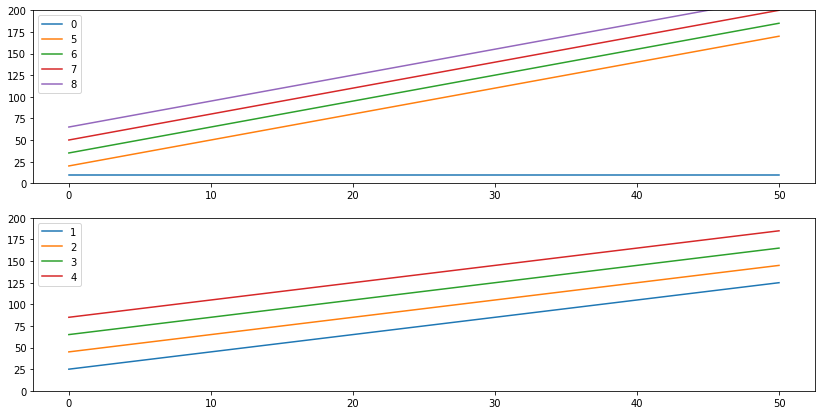

In [604]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[14,7])
fig.add_subplot(211)
x = tmp[:,0,tIdx]
y = tmp[:,np.argwhere(lanes).reshape(-1),xIdx]
plt.plot(x,y)
plt.ylim((0,200))
plt.legend(np.argwhere(lanes).reshape(-1))
fig.add_subplot(212)
lanes_other = [abs(1-i) for i in lanes]
y = tmp[:,np.argwhere(lanes_other).reshape(-1),xIdx]
plt.plot(x,y)
plt.ylim((0,200))
plt.legend(np.argwhere(lanes_other).reshape(-1))

### Scenario planning

In [ ]:
## Scenario: constant vel
state = tuple([0, 85, 18.5, 2, 0])
path = [state]
path += gen1stCar(path[-1],50,path[-1][vxIdx])
path

In [ ]:
## Scenario: traffic jam (stuck)
state = tuple([0, 85, 18.5, 2, 0])
path = [state]
period = 0.5
for i in range(5):    
    path += gen1stCar(path[-1], 1,0)
    path += gen1stCar(path[-1], 0.5,1)
for i in range(15):    
    path += gen1stCar(path[-1], 0.5,0)
    path += gen1stCar(path[-1], 2,2)
path

In [ ]:
## Scenario: traffic jam (clears after some time)
state = tuple([0, 85, 18.5, 2, 0])
path = [state]
period = 0.5
for i in range(8):    
    path += gen1stCar(path[-1], 1,0)
    path += gen1stCar(path[-1], 0.5,1)

path += gen1stCar(path[-1], 38,2)
path

In [ ]:
## Scenario: traffic jam
state = tuple([0, 85, 18.5, 2, 0])
path = [state]
path += gen1stCar(path[-1],1,1)
path += gen1stCar(path[-1],2,0)
path += gen1stCar(path[-1],2,vMAX)
path += gen1stCar(path[-1],2,vMAX)
path